In [ ]:
!pip install transformers datasets torch_cka huggingface_hub matplotlib seaborn tqdm nnsight

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
import os
import pickle
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import re

In [ ]:
# Hugging Face login
from huggingface_hub import login
api_token = "HF_API_TOKEN" # Replace with your actual token
login(api_token)

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

### example 1: base q

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

🔻 Biggest hidden-state norm drop at layer 12


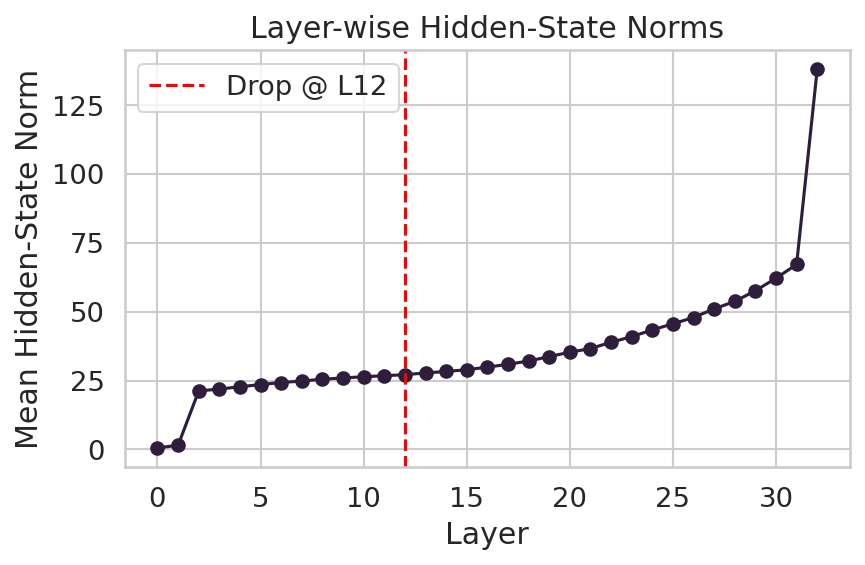

Next‐token probabilities:
  Position  1 | Token 'D' | P = 0.0025
  Position  2 | Token 'Ġis' | P = 0.0003
  Position  3 | Token 'Ġthe' | P = 0.0284
  Position  4 | Token 'Ġwife' | P = 0.0007
  Position  5 | Token 'Ġof' | P = 0.8594
  Position  6 | Token 'ĠC' | P = 0.0708
  Position  7 | Token ',' | P = 0.2461
  Position  8 | Token 'ĠC' | P = 0.0425
  Position  9 | Token 'Ġis' | P = 0.7930
  Position 10 | Token 'Ġthe' | P = 0.9219
  Position 11 | Token 'Ġgreat' | P = 0.0004
  Position 12 | Token 'grand' | P = 0.0096
  Position 13 | Token 'father' | P = 0.3223
  Position 14 | Token ''s' | P = 0.0004
  Position 15 | Token 'Ġonly' | P = 0.0121
  Position 16 | Token 'Ġgrandson' | P = 0.0221
  Position 17 | Token ',' | P = 0.4082
  Position 18 | Token 'Ġhow' | P = 0.0106
  Position 19 | Token 'Ġis' | P = 0.8438
  Position 20 | Token 'ĠD' | P = 0.7539
  Position 21 | Token 'Ġrelated' | P = 0.9453
  Position 22 | Token 'Ġto' | P = 0.9883
  Position 23 | Token 'ĠF' | P = 0.0099
  Position 24 | 

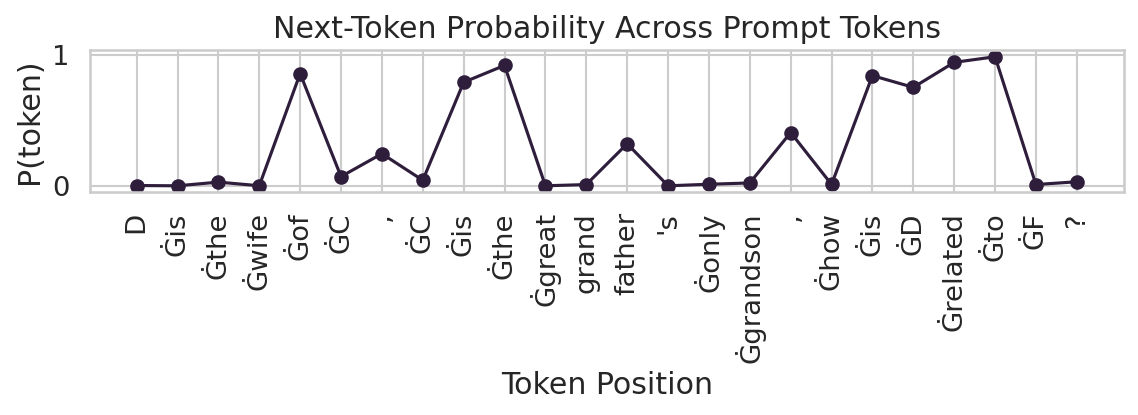

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import numpy as np

# ─── Setup ──────────────────────────────────────────────────────────────────────
model_name = "meta-llama/Llama-3.1-8B"
# device     = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    output_hidden_states=True,
    device_map="auto",
    torch_dtype=torch.bfloat16
)
model.eval()

prompt = ("D is the wife of C, C is the greatgrandfather's only grandson, how is D related to F?")
inputs = tokenizer(prompt, return_tensors="pt")

# ─── Forward Pass ────────────────────────────────────────────────────────────────
with torch.no_grad():
    outputs = model(**inputs)

hidden_states = outputs.hidden_states  # tuple of length num_layers+1
input_ids     = inputs.input_ids[0]    # (seq_len,)

# ─── 1) Layer-wise Norm Drop ────────────────────────────────────────────────────
# Compute mean L2 norm (cast to float32 first) per layer
mean_norms = []
for hs in hidden_states:
    # hs: (1, seq_len, hidden_dim)
    norms = hs[0].to(torch.float32).norm(dim=-1).cpu().numpy()  # (seq_len,)
    mean_norms.append(norms.mean())
mean_norms = np.array(mean_norms)

# Find the layer with the largest negative jump
diffs = mean_norms[1:] - mean_norms[:-1]
drop_layer = int(np.argmin(diffs) + 1)
print(f"🔻 Biggest hidden-state norm drop at layer {drop_layer}")

# Plot
plt.figure(figsize=(6,4))
plt.plot(range(len(mean_norms)), mean_norms, marker='o')
plt.axvline(drop_layer, color='red', linestyle='--', label=f"Drop @ L{drop_layer}")
plt.xlabel("Layer")
plt.ylabel("Mean Hidden-State Norm")
plt.title("Layer-wise Hidden-State Norms")
plt.legend()
plt.tight_layout()
plt.show()


# ─── 2) Token-wise Next-Token Probabilities ──────────────────────────────────────

probs = []
for i in range(1, len(input_ids)):
    with torch.no_grad():
        out = model(input_ids=input_ids[:i].unsqueeze(0))
        logits_i = out.logits[0, -1]                  # (vocab_size,)
        p_true   = torch.softmax(logits_i, dim=-1)[input_ids[i]].item()
        probs.append(p_true)

tokens = tokenizer.convert_ids_to_tokens(input_ids)

# ─── Print them in a readable way ───────────────────────────────────────────────
print("Next‐token probabilities:")
for pos, prob in zip(range(1, len(tokens)), probs):
    print(f"  Position {pos:2d} | Token '{tokens[pos]}' | P = {prob:.4f}")

# ─── Identify min/max ──────────────────────────────────────────────────────────
min_pos = int(np.argmin(probs) + 1)
max_pos = int(np.argmax(probs) + 1)
print(f"\n🔽 Lowest P at token {min_pos} (‘{tokens[min_pos]}’): {probs[min_pos-1]:.4f}")
print(f"🔼 Highest P at token {max_pos} (‘{tokens[max_pos]}’): {probs[max_pos-1]:.4f}")

# ─── Plot ───────────────────────────────────────────────────────────────────────
positions = np.arange(1, len(tokens))
plt.figure(figsize=(8,3))
plt.plot(positions, probs, marker='o')
plt.xticks(positions, tokens[1:], rotation=90)
plt.xlabel("Token Position")
plt.ylabel("P(token)")
plt.title("Next‐Token Probability Across Prompt Tokens")
plt.tight_layout()
plt.show()
